# Application of A/B testing
# Project: Pricing Test --- Should the Company Increase Price?

## Key Words: **A/B testing, Sanity Check, t-test, P-value, Chi2-test, Decision Tree**

## **Background:**

Often company need to run test to decide if incresing price would increase revenue. Herein, this project is to evaluate whether a pricing test running on the site has been successful( changing the price from 39 to 59). In the experiment, 66% of the users have seen the old price, while a random sample of 33% users a higher price. I will focus on user segmentation and provided insights about segments who behave differently. 

Two questions can be solved here:


**Question 1: Should the company sell its products for previous or higher price?**


**Question 2: Is there any actionalbe insights that might increase conversion rate?**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

## Table of Contents
  1. [Understand Problem & Objectives](#understand)
  
  2. [Design Experiment](#design)
  
  3. [Implement](#implement)     
  3.1 [Data Preparation](#datap)  
  3.2 [Data Exploration](#datae)        
        [Check Test/Control Ratio](#checkt)        
        [Check for mixed assignment](#checkf)        
        [Sanity Check](#sanity)
        
  4. [Question 1](#question1)  
  
  5. [Question 2](#question2)      
  [Chi-Square Test](#ctest)  
  [Decision Tree](#model)
  [Actionable Insights](#act)  

<a id='understand'></a>
## Understand Problem & Objectives:
**Change:** Change the price from 39 to 59

**Goal:** increase revenue

<a id='design'></a>
## Design Experiment
**Choose Metrics:**

Since the goal is to improve revenue, choose revenue as metrics. Then I will use **A/B testing** to investigate if the increase of price will lead to more revenue.

**Statistics Hypothesis:**

H0: test group's average revenue = control group's average revenue;
    
HA: test group's average revenue > control group's average revenue

<a id='implement'></a>
## Implement
<a id='datap'></a>
### Data Preparation

In [3]:
# read "test" table and use the user_id as index
test = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/6. Pricing_Test/test_results.csv')
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
# Check the basic information: data type, null values
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


<a id='datae'></a>
### Data Exploration
<a id='checkt'></a>
#### Check Test / Control Ratio

I will firstly check if the ratio of test/control matched the description. Herein, 66% of the users have seen the old price, while a random sample of 33% users a higher price. Therefore, the ratio should be about 2.

In [8]:
test.groupby('test')['user_id'].count()

test
0    202727
1    114073
Name: user_id, dtype: int64

It can be found that the ratio of test/control roughly matched the description.

<a id='checkf'></a>
#### Check for mixed assignment

In [10]:
# check if there are sampling bias problem
test.groupby(['test','price'])['user_id'].count()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: user_id, dtype: int64

It can be seen that in control some users can see price 59, while in test some users still see the old price. So, assignment has mixed, since the mixed samples is small, I will remove them.

In [11]:
# remove the unvalid data and only keep the valid data
test = test[((test['test'] == 0) & (test['price'] == 39)) | ((test['test'] == 1) & (test['price'] == 59))]

<a id='sanity'></a>
#### Sanity Check
The key assumptions for testing are 1) The factor to test is the only reason for difference; 2) A unit been assigned to A or B is random; 3) Each experiment unit are independent. To verify the assumptions, I will do sanity check.

In [14]:
# Transfer the categorical columns to be numbers
test1 = test.copy()
test1['source']=LabelEncoder().fit_transform(test1['source'])
test1['device']=LabelEncoder().fit_transform(test1['device'])
test1['operative_system']=LabelEncoder().fit_transform(test1['operative_system'])
test1.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,3,0,1,0,39,0
1,624057,2015-05-10 21:08:46,8,0,0,0,39,0
2,317970,2015-04-04 15:01:23,0,0,0,0,39,0
3,685636,2015-05-07 07:26:01,5,0,1,1,59,0
4,820854,2015-05-24 11:04:40,3,1,3,0,39,0


After transfering categorical fields to be numerical, I need to check the relationship between the categorical with the 'test'. That is to say to check if these fields has some relationship with the test chosen. I will  run Chi2 test to see if these categorical fields have effects on splitting between control and test groups.

In [18]:
# Choose categorical fields and run chi2 test
columns = ['source','device','operative_system']
ch2values,pvalues = chi2(test1[columns],test1["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = columns).sort_values(by='pvalue')

,chi2_value,pvalue
operative_system,83.937937,5.105534e-20
device,44.785346,2.198620e-11
source,0.918060,3.379849e-01


From above result, it can be known that "both operative_system" and "device" has some relationship with test, which means they are not independent.Operative system and device do has some impact on the splitting. 

Let's further explore which part of the operative system and device didn't obey the rules.

In [21]:
# define the function to check the percentage of each components
def dis_ratios(data):
    return data.value_counts(normalize = True)

In [20]:
# Check the operative-system 
os_test = test.groupby('operative_system')['test'].apply(dis_ratios).unstack()
os_test

,0,1
operative_system,,
android,0.643475,0.356525
iOS,0.648045,0.351955
linux,0.533656,0.466344
mac,0.652365,0.347635
other,0.647895,0.352105
windows,0.629817,0.370183


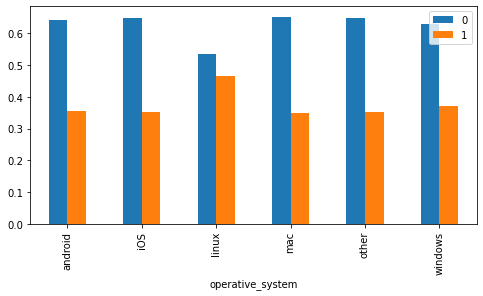

In [21]:
# visualize the relationship beteen detailed operative system and their ratios in test/control
os_test.plot(kind = 'bar',figsize=(8,4))

It is very clearly that "Linux" is abnormal since the experimental claim that 66% of the users saw the 39, while a random sample of 33% users use the 59, but clients using linux don't obey this rule.(nearly 53% go to control group, while 47% go to test group).

In [22]:
# check how the "device" infulence the test/control experiment
de_test = test.groupby('device')['test'].apply(dis_ratios).unstack()
de_test

,0,1
device,,
mobile,0.646218,0.353782
web,0.631092,0.368908


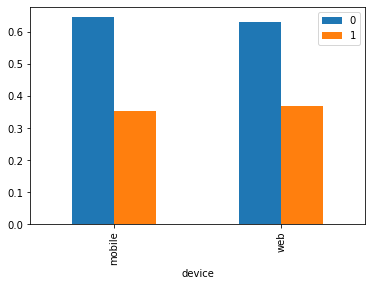

In [23]:
# visulaize the rationship between different device and their ratios in test/control
de_test.plot(kind = 'bar')

It can been seen from the above device barplot that the ratio between test and control in diferent devices are a little different so that can be ignored. The reason why this has been listed as a higher chi2 values in chi2 test maybe because chi2 test is sensitive to sample size and when sample size is very large, small difference will appear statistically significant.However, after the further analysis, the effect of 'device' on the test/control splitting can be ignored.

<a id='question1'></a>
## Question 1

Should the company sell its software for 39 or 59?


To answer this question, I need to firstly check the averaged revenue, then run **t-test** to check **p-value**.

In [24]:
# check the convert rate and average revenue for 39 and 59
test['revenue'] = test['price'] * test['converted']

summary = pd.DataFrame({'convert_rate': test.groupby('test')['converted'].mean(),
                         'total_revenue': test.groupby('test')['revenue'].sum(),
                         'average_revenue': test.groupby('test')['revenue'].mean()})
summary

,convert_rate,total_revenue,average_revenue
test,,,
0,0.019900,157170,0.776083
1,0.015555,104548,0.917748


In [71]:
# calculate the p_value of t-test
a = test[test['test']==0]['revenue']
b = test[test['test']==1]['revenue']
t_test_result = ss.ttest_ind(a, b,equal_var = False)

# ttest_ind is a two tailed, 
# since the HA is test average revenue > control average revenue
# its pvalues should be divided by 2
p_value = t_test_result.pvalue/2
p_value

5.486288656210391e-09

**Answer to Q1:**

Since the p-value is much smaller than 0.05, so H0 can be safely rejected and HA can be accepted, which means the test groups'average revenue is significantly higher than the control groups'.

However, as shown before, the operative system distribution in the test and control groups are not the same, so price isn't the only difference between these two groups, the higher average revenue can't be only contributed to price.

Based on the current experiment, I can't answer which price the company should choose, and I would suggest firstly find the reason why linux users have different ratio in control/test, then modify the experiment and make sure the user are randomly chosen, then rerun the experiment.Then the conclusion can be accurately made.

<a id='question2'></a>
## Question 2
Are there any actionable insights that might increase conversion rate? 

In [49]:
# transfer the price into numerical features
test1['price']= (test1['price']== 39).astype(np.int)

In [52]:
test1.head()

,user_id,source,device,operative_system,test,price,converted,revenue
0,604839,3,0,1,0,1,0,0
1,624057,8,0,0,0,1,0,0
2,317970,0,0,0,0,1,0,0
3,685636,5,0,1,1,0,0,0
4,820854,3,1,3,0,1,0,0


<a id='ctest'></a>
### Chi-Square test

In [53]:
# run chi2 test to see which feature greatly impact "converted"
columns = ['source','device','operative_system','price']
ch2values,pvalues = chi2(test1[columns],test1["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = columns).sort_values(by='pvalue')

,chi2_value,pvalue
price,27.523496,1.551976e-07
operative_system,7.378510,6.600782e-03
source,2.451427,1.174181e-01
device,0.706940,4.004615e-01


It can be found from above result, 'price' and 'operative_system' are two main factor which impact converted more. And "source" and 'device' didn't show impact on conversion rate.

In [56]:
# check how price affects converted
price_converted = test.groupby('price')['converted'].apply(lambda a: a.value_counts(normalize = True)).unstack()
price_converted

,0,1
price,,
39,0.980100,0.019900
59,0.984445,0.015555


It can be found that uses who see 59 dollars showed lower conversion rate than users who see 39 dollars.

In [57]:
# chek how operative_system affects convertion rate
os_converted = test.groupby('operative_system')['converted'].apply(lambda a: a.value_counts(normalize =True)).unstack().sort_values(by=1)
os_converted

,0,1
operative_system,,
linux,0.991768,0.008232
other,0.987019,0.012981
android,0.985081,0.014919
windows,0.983034,0.016966
iOS,0.977672,0.022328
mac,0.976013,0.023987


In [60]:
converted_os = test.groupby('converted')['operative_system'].apply(lambda a:a.value_counts(normalize = True)).unstack()
converted_os                                                      

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237428,0.300110,0.013186,0.078723,0.051401,0.319152
1,0.192520,0.366942,0.005860,0.103585,0.036194,0.294898


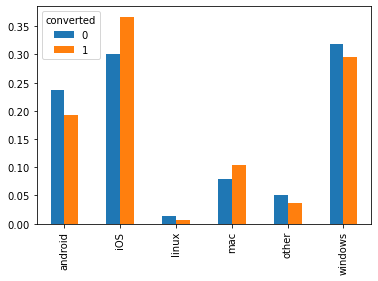

In [63]:
# visualize the conversion_rate of different operative system
converted_os.T.plot(kind='bar')

It can be found that iOS and mac users have higher conversion rate than users from other operative system.

Linus users showed lower conversion rate than users from other operative system.

<a id='model'></a>
### Decision Tree
I will build a Decision Tree to get important features.Since I want to get the detailed operative system or device, source effect on the conversion rate, I will use One-Hot-Encoding to transfer categorical features to numbers

In [68]:
# Drop unnecessary columns
test2 = test.copy()
test2 = test2.drop(columns=['timestamp','test','revenue','user_id'])

# one-hot encoding categorical features
test2 = pd.get_dummies(test2)
test2 = test2.drop(columns=['operative_system_other','device_web','source_ads_other'])

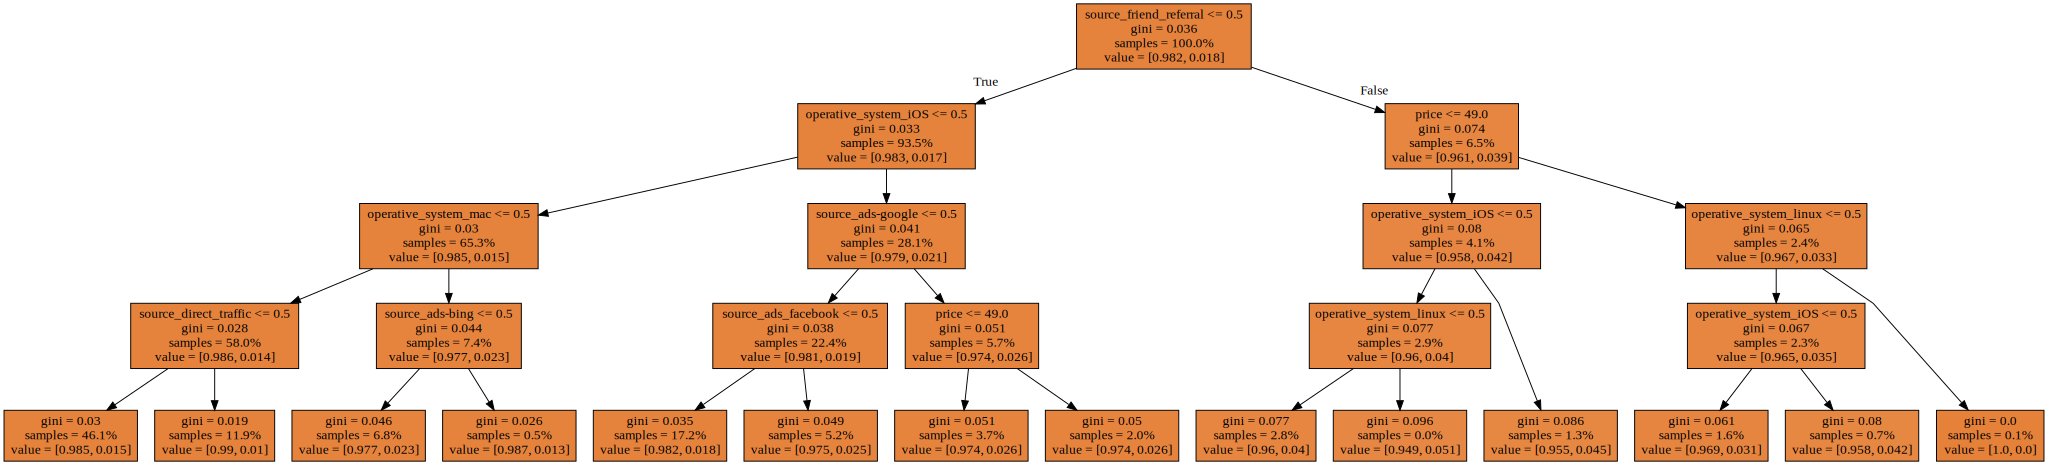

In [71]:
# split the data
xtrain = test2.drop(columns='converted')
ytrain = test2['converted']

# build and train the model, visualization t
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(xtrain,ytrain)
dot_data = tree.export_graphviz(dt,feature_names=xtrain.columns,proportion=True, filled = True,leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph

It can be seen from Decision Tree, to reach the leaf node with highest converstion rate, the path is

1). source_friend_referral = True, 

2). price<49, 

3). operative_system_ios=True.

In [72]:
# check feature imporatance using sklean in built function
pd.Series(dt.feature_importances_,index = xtrain.columns).sort_values(ascending = False)

source_friend_referral      0.581165
operative_system_iOS        0.136965
operative_system_mac        0.093429
source_direct_traffic       0.059473
source_ads_facebook         0.041326
source_ads-google           0.038754
price                       0.020501
operative_system_linux      0.017944
source_ads-bing             0.010442
source_ads-yahoo            0.000000
operative_system_windows    0.000000
source_seo-bing             0.000000
source_seo-other            0.000000
source_seo-yahoo            0.000000
source_seo_facebook         0.000000
device_mobile               0.000000
operative_system_android    0.000000
source_seo-google           0.000000
dtype: float64

<a id='act'></a>
### Actionable Insights

1.  'price' and 'operative_system' are two main genearal factors which impact converted more. And higher price showed lower conversion rate compared with that of lower price. This makes sense since there are relatively fewer people to buy products with higher price.


2. Mac and iOS has higher conversion rate compared with those using other operative system. Since all the users are in Amercia and people in American perfer to products from Apple, so we can increase the ad appeared on mac and iphone and launch special marketing progream targeted to Apple users.


3. Linux User showed the lowest conversion rate. Development team should find out the reason. For example, if is there any incompatibility issue on Linux? Is the propaganda that software works well in Linux not enough? 


4. Friend_referral,apple user(Mac and iOS), low price are main detailed positive factors that improve the conversion rate. If you want to increase the price, we must compensate on the other two factors. For example, rewards user who invite his/her friend to use the software.

In [4]:
test.groupby('operative_system')['user_id'].apply(lambda a:a.value_counts(normalize = True))


operative_system        
android           657407    0.000013
                  664337    0.000013
                  856823    0.000013
                  357115    0.000013
                  436992    0.000013
                              ...   
windows           281672    0.000010
                  397332    0.000010
                  946200    0.000010
                  813285    0.000010
                  266242    0.000010
Name: user_id, Length: 316800, dtype: float64

In [5]:
test['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: operative_system, dtype: int64